In [3]:
# Setup
# Imports


import torch as t
import matplotlib.pyplot as plt
import importlib
import numpy as np
import einops

from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_aes
)

%load_ext autoreload
%autoreload 2


# device = 'cuda:0'
device = 'cpu'
repo_dir = '/share/u/can/chess-gpt-circuits'

# Import model
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
model = get_model(model_name, device)
aes = get_aes(node_type='mlp_neuron', repo_dir=repo_dir)
ae0 = aes[0]

# Load data
context_length = 59
activation_dim = 512  # output dimension of the layer
batch_size = 64
dataset_name = "taufeeque/othellogpt"
data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)
games_batch = [next(data) for _ in range(batch_size)]
games_batch = t.tensor(games_batch, device=device)

tracer_kwargs = {'scan': False, 'validate': False}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cpu


### Motivation:
- Cosine sim of embedding and unembedding is insigificant, see cell below. 
- However, mean ablating specific tokens in the embedding seems to have a high effect in the logit directions

### Setup
1. Only most recent move, start with single token: 10 == C1
    - get a batch of game sequences up until a specific move
    - get activation diffs for embedding, attn0, resid_mid for mean ablating the token
    - DLA, unembed those activation differences
2. Ablation at any position


Text(0.5, 1.0, 'Cosine similarity between embedding and unembedding')

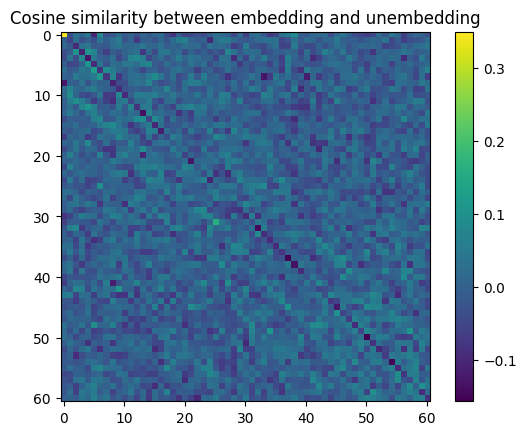

In [4]:
# Comparison of model embeddings
we_norm = t.norm(model.W_E, dim=-1)
wu_norm = t.norm(model.W_U, dim=0)
embedding_cos_sim = model.W_E @ model.W_U / (we_norm[:, None] * wu_norm[None, :])
import matplotlib.pyplot as plt
plt.imshow(embedding_cos_sim.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Cosine similarity between embedding and unembedding')

In [5]:
# get mean embeddings per position across games batch
with t.no_grad(), model.trace(games_batch, **tracer_kwargs):
    # embed_acts = model.blocks[0].hook_resid_pre.output.save()
    embed_acts = model.hook_embed.output.save()
mean_embeds = embed_acts.sum(dim=0) # shape [pos, dm]

In [6]:
# Logit diff direction on a single batch of inputs for mean ablating input tokens
# find index where games_batch[0] is 10

game = t.tensor(games_batch[0])
move_token_id = 10
move_pos = t.where(game == move_token_id)[0]

/tmp/ipykernel_412994/3838304699.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  game = t.tensor(games_batch[0])


In [7]:
# Get clean embed, attn0, resid_mid_0 acts
with t.no_grad(), model.trace(game, **tracer_kwargs):
    embed_act_clean = model.blocks[0].hook_resid_pre.output.save()
    attn0_act_clean = model.blocks[0].hook_attn_out.output.save()
    resid_mid_0_act_clean = model.blocks[0].hook_resid_mid.output.save()

# Get patch embed, attn0, resid_mid_0 acts
embed_act_patch = embed_act_clean.clone()
batch_arange = t.arange(embed_act_patch.shape[0])
embed_act_patch[batch_arange, move_pos] = mean_embeds[batch_arange, move_pos]

with t.no_grad(), model.trace(game, **tracer_kwargs):
    model.blocks[0].hook_resid_pre.output = embed_act_patch
    attn0_act_patch = model.blocks[0].hook_attn_out.output.save()
    resid_mid_0_act_patch = model.blocks[0].hook_resid_mid.output.save()

# Get diff in activations
embed_act_diff = embed_act_patch - embed_act_clean
attn0_act_diff = attn0_act_patch - attn0_act_clean
resid_mid_0_act_diff = resid_mid_0_act_patch - resid_mid_0_act_clean

# Normalize diff in activations
embed_act_diff_norm = t.norm(embed_act_diff, dim=-1, keepdim=True)
attn0_act_diff_norm = t.norm(attn0_act_diff, dim=-1, keepdim=True)
resid_mid_0_act_diff_norm = t.norm(resid_mid_0_act_diff, dim=-1, keepdim=True)

In [8]:
# Get diff in logit directions
WU_norm = t.norm(model.W_U[:, 1:], dim=0, keepdim=True)

embed_dla = embed_act_diff @ model.W_U[:, 1:] / (embed_act_diff_norm * WU_norm)
attn0_dla = attn0_act_diff @ model.W_U[:, 1:] / (attn0_act_diff_norm * WU_norm)
resid_mid_0_dla = resid_mid_0_act_diff @ model.W_U[:, 1:] / (resid_mid_0_act_diff_norm * WU_norm)

In [9]:
import importlib
import feature_viz_othello_utils
importlib.reload(feature_viz_othello_utils) 

batch_test_idx = 0
pos_test_idx = 0
player = feature_viz_othello_utils.BoardPlayer(game)

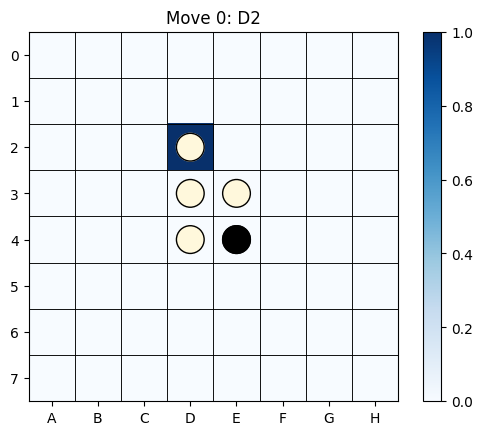

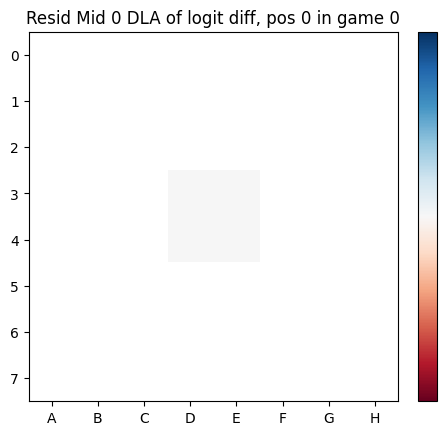

In [10]:
player.next()

fig, ax = plt.subplots()
feature_viz_othello_utils.visualize_vocab(ax, resid_mid_0_dla[batch_test_idx, pos_test_idx], device)
ax.set_title(f'Resid Mid 0 DLA of logit diff, pos {pos_test_idx} in game {batch_test_idx}')
pos_test_idx+=1


## Evidence towards attn heads map embedding space to unembedding space

model

In [11]:
W_OV = einops.einsum(model.W_V[0], model.W_O[0], 'nh dm1 dh, nh dh dm2 -> nh dm1 dm2')
W_OV.shape

torch.Size([8, 512, 512])

In [12]:
mean_embeds.shape

torch.Size([59, 512])

In [13]:
t_mean = mean_embeds[10, :]
t_E = model.W_E[10, :]
t_U = model.W_U[:, 10]
t_U_norm = t_U / t.norm(t_U)

In [14]:
t_outs = W_OV @ t_E
t_outs_norm = t_outs / t.norm(t_outs, dim=-1, keepdim=True)

t_outs_mean = W_OV @ t_mean
t_outs_mean_norm = t_outs_mean / t.norm(t_outs_mean, dim=-1, keepdim=True)

In [15]:
cos_sim_out_u = t_outs_mean_norm @ t_U_norm
cos_sim_out_u

tensor([-0.0493, -0.0214, -0.0091,  0.0488, -0.0341, -0.0291,  0.0077, -0.0576],
       grad_fn=<MvBackward0>)